In [10]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text as tx
from scipy.sparse import coo_matrix, hstack
import langdetect as ld
import nltk
from nltk.corpus import words as nltk_words #need to download corpus using nltk.download() prior to use
import enchant


In [ ]:
# Use Enchant English Dictionary
d = enchant.Dict("en_US")
plt.style.use('seaborn-darkgrid')
%matplotlib inline


In [ ]:
df = pd.read_csv(os.path.join('data', 'train.csv'), parse_dates=['date'], index_col=['ex_id'])

### Target Distribution

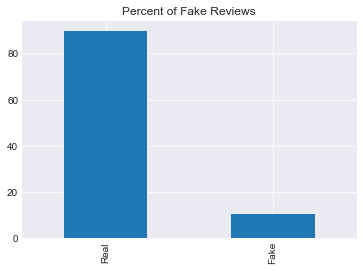

In [223]:
(100*df['label'].value_counts()/len(df)).rename({0:'Real', 1:'Fake'}).plot.bar(title='Percent of Fake Reviews');

In [ ]:
# Are fake reviews linked to reviewers?

In [254]:
pct_fake_user = 100*df.groupby('user_id')['label'].sum()/df.groupby('user_id')['label'].count()

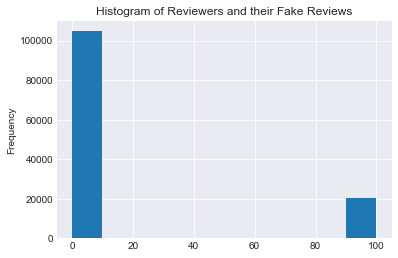

In [255]:
pct_fake_user.plot.hist(title='Histogram of Reviewers and their Fake Reviews');

In [256]:
100*pct_fake_user.value_counts()/len(pct_fake_user)

0.000000      83.285990
100.000000    16.394943
50.000000      0.136061
33.333333      0.053310
25.000000      0.027849
20.000000      0.014322
66.666667      0.013527
16.666667      0.012731
12.500000      0.007161
8.333333       0.004774
14.285714      0.003978
11.111111      0.003978
10.000000      0.002387
75.000000      0.002387
40.000000      0.002387
9.090909       0.002387
4.545455       0.002387
3.571429       0.001591
60.000000      0.001591
7.692308       0.001591
83.333333      0.001591
18.181818      0.001591
7.142857       0.000796
3.846154       0.000796
27.272727      0.000796
5.882353       0.000796
80.000000      0.000796
5.263158       0.000796
44.444444      0.000796
72.222222      0.000796
4.081633       0.000796
7.407407       0.000796
90.909091      0.000796
41.176471      0.000796
34.883721      0.000796
52.173913      0.000796
54.545455      0.000796
60.869565      0.000796
91.666667      0.000796
13.333333      0.000796
67.741935      0.000796
3.703704       0

Rather than targetting reviews, we could potentially structure this as a problem to identify bad users.

In [ ]:
# How does the distribution look for products?

In [257]:
pct_fake_prod = 100*df.groupby('prod_id')['label'].sum()/df.groupby('prod_id')['label'].count()

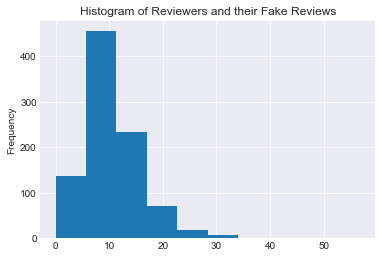

In [258]:
pct_fake_prod.plot.hist(title='Histogram of Reviewers and their Fake Reviews');

In [259]:
100*pct_fake_prod.value_counts()/len(pct_fake_prod)

0.000000     2.166847
11.111111    0.975081
10.000000    0.975081
6.666667     0.866739
9.090909     0.758397
               ...   
2.127660     0.108342
15.068493    0.108342
2.777778     0.108342
10.972569    0.108342
10.301109    0.108342
Name: label, Length: 672, dtype: float64

The link between real and fake reviews is less strong than I would've expected. Perhaps that's because fake reviews lead real reviews?

In [260]:
prod_meta = pd.DataFrame(index=df['prod_id'].unique())

In [261]:
prod_meta['prod_first_date'] = df.set_index('prod_id').groupby(level=0)['date'].min()
prod_meta['prod_last_date'] = df.set_index('prod_id').groupby(level=0)['date'].max()  

In [263]:
# No Products have only 1 date!
(prod_meta['prod_first_date'] == prod_meta['prod_last_date']).sum()

0

However, should probably still account for that potential corner case in the validation and/or test set

In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250874 entries, 0 to 250873
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          250874 non-null  int64         
 1   prod_id          250874 non-null  int64         
 2   rating           250874 non-null  float64       
 3   label            250874 non-null  int64         
 4   date             250874 non-null  datetime64[ns]
 5   review           250874 non-null  object        
 6   lang             250874 non-null  object        
 7   lang_conf        250850 non-null  float64       
 8   pct_en           250841 non-null  float64       
 9   word_count       250874 non-null  int64         
 10  prod_first_date  250874 non-null  datetime64[ns]
 11  prod_last_date   250874 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(3), int64(4), object(2)
memory usage: 34.9+ MB


In [270]:
df = df.merge(prod_meta.reset_index(), left_on='prod_id', right_on='index', how='left').drop(columns='index')

In [283]:
df['pct_from_start'] = (df['date']-df['prod_first_date'])/(df['prod_last_date']-df['prod_first_date'])
df['pct_from_start'] = 100*df['pct_from_start']

In [287]:
df.groupby('label')['pct_from_start'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,225055.0,59.751486,27.030930,0.0,39.666866,62.825166,83.121071,100.0
1,25819.0,59.481061,28.144838,0.0,39.778870,63.477995,83.675138,100.0


There does not appear to be an obvious relationship between the time of the review and whether or not it was fake.

In [288]:
df['days_from_start'] = (df['date']-df['prod_first_date'])

In [289]:
df.groupby('label')['days_from_start'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,225055,1454 days 10:08:45.599520,963 days 04:36:30.270269,0 days,598 days 00:00:00,1366 days,2234 days,3730 days
1,25819,1514 days 15:25:43.096167,1011 days 21:09:14.664223,0 days,571 days 12:00:00,1485 days,2362 days,3725 days


### Review Distribution

In [143]:
# What proportion of words are standard english words?
count_trans = tx.CountVectorizer(strip_accents='unicode').fit(df['review'])
count_vect = count_trans.transform(df['review'])


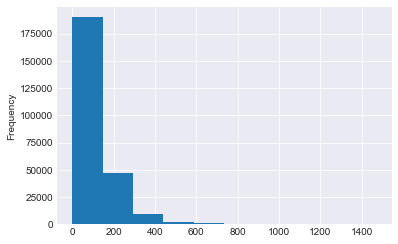

In [147]:
df['word_count'] = count_vect.sum(axis=1)
df['word_count'].plot.hist('Histogram of Words per Review');

In [148]:
df['word_count'].describe()

count    250874.000000
mean        110.026045
std         100.769863
min           0.000000
25%          42.000000
50%          81.000000
75%         145.000000
max        1472.000000
Name: word_count, dtype: float64

**Question:** How to handle reviews w/ out any text?

In [154]:
vocab = pd.DataFrame(count_vect.sum(axis=0).T, columns=['count'], index=count_trans.get_feature_names())

In [163]:
vocab['pct_words'] = 100*vocab['count']/vocab['count'].sum()

In [158]:
vocab['ndocs'] = np.sum(count_vect >= 1, axis=0).T

In [166]:
vocab['pct_docs'] = 100*vocab['ndocs']/len(df)

In [167]:
vocab.describe()

,count,pct_words,ndocs,pct_docs
count,1.078130e+05,107813.000000,107813.000000,107813.000000
mean,2.560236e+02,0.000928,174.731646,0.069649
std,7.676597e+03,0.027811,2690.796830,1.072569
min,1.000000e+00,0.000004,1.000000,0.000399
25%,1.000000e+00,0.000004,1.000000,0.000399
50%,2.000000e+00,0.000007,2.000000,0.000797
75%,8.000000e+00,0.000029,8.000000,0.003189
max,1.619924e+06,5.868721,228010.000000,90.886262


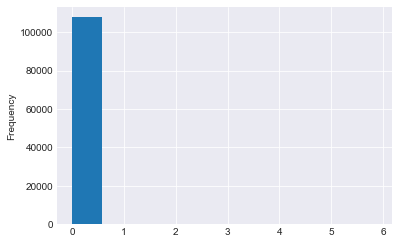

In [164]:
vocab['pct_words'].plot.hist('Histogram of Word Frequency');

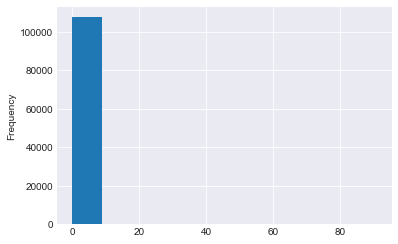

In [168]:
vocab['pct_docs'].plot.hist('Histogram of Doc Frequency');

### Language Detection

In [32]:
def lang_detect (z):
    try:
        out = ld.detect_langs(z)[0]
    except:
        out = None
    return out
    

In [33]:
df['lang'] = df['review'].apply(lambda z: lang_detect(z))

In [54]:
df = df.drop(columns=['lang']).join(df['lang'].astype('str').str.split(":", expand=True)).rename(columns={0:'lang', 1:'lang_conf'})

In [55]:
# Nearly every review is in english
df['lang'].value_counts()

en       249128
it          269
af          150
so          109
nl          105
ca          103
de          101
fr           98
no           86
da           70
cy           69
tl           68
es           66
ro           62
tr           59
sl           43
id           42
sw           40
hr           27
pl           26
sv           24
None         24
et           24
pt           19
fi           17
cs           11
hu           10
sq           10
sk            4
ja            3
lt            3
lv            2
zh-cn         1
vi            1
Name: lang, dtype: int64

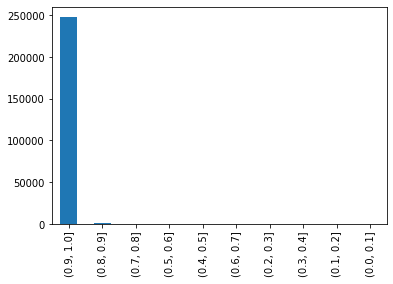

In [118]:
# nearly all data are classified with a high probability

pd.cut(df.loc[df['lang'] == 'en', 'lang_conf'], np.arange(0,1.1,0.1).tolist()).value_counts().plot.bar();

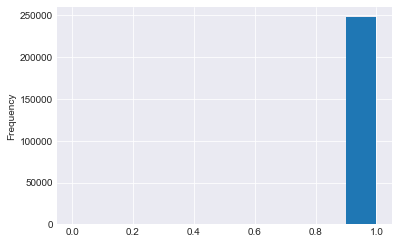

In [126]:
df.loc[df['lang'] == 'en', 'lang_conf'].plot.hist(bins=np.arange(0,1.1,0.1));

In [131]:
pd.cut(df.loc[df['lang'] == 'en', 'lang_conf'], bins=np.arange(0,1.1,0.1)).value_counts()

(0.9, 1.0]    247833
(0.8, 0.9]       811
(0.7, 0.8]       266
(0.5, 0.6]       183
(0.4, 0.5]        33
(0.6, 0.7]         1
(0.2, 0.3]         1
(0.3, 0.4]         0
(0.1, 0.2]         0
(0.0, 0.1]         0
Name: lang_conf, dtype: int64

In [102]:
vocab = pd.DataFrame(count_vect.sum(axis=0).T, columns=['word_count'],
                      index=count_trans.get_feature_names())

In [103]:
vocab.sort_values(by='word_count', ascending=False, inplace=True)
vocab.reset_index(inplace=True)
vocab.rename(columns={'index':'word'}, inplace=True)

In [195]:
vocab['en'] = vocab['word'].apply(lambda z: d.check(z))

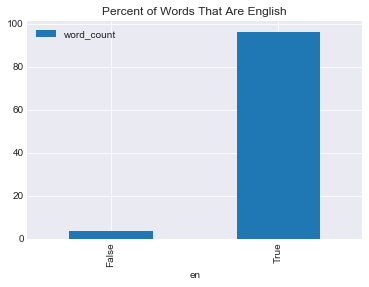

In [142]:
pd.DataFrame(100*vocab.loc[:, ['en','word_count']].groupby('en').sum()/vocab['word_count'].sum()).plot.bar(
    title='Percent of Words That Are English');

In [ ]:
# what about the pct of the corpus?

In [106]:
100*vocab['en'].sum()/len(vocab)

38.8867761772699

A vast proportion of the words in reviews are not english language (despite our reviews being largely identified as english. This suggests a lot of improper text.

It could be interesting to classify our reviews based solely on their proper english words)

In [114]:
# How does that distribution look at the document level?
en_list = vocab.loc[vocab['en'], 'word'].tolist()
en_idx = [count_trans.vocabulary_[x] for x in en_list]

C:\Users\tfconnor\Anaconda3\envs\DEFAULT\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



matrix([[ 94.73684211],
        [ 95.91836735],
        [ 96.77419355],
        ...,
        [ 96.1038961 ],
        [100.        ],
        [ 97.39663093]])

In [115]:
df['pct_en'] = 100*count_vect[:, en_idx].sum(axis=1)/count_vect.sum(axis=1)


C:\Users\tfconnor\Anaconda3\envs\DEFAULT\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



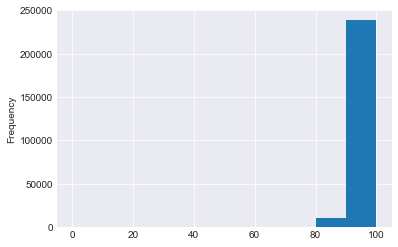

In [136]:
df['pct_en'].plot.hist(bins=np.arange(0,110,10));

In [139]:
100*(pd.cut(df['pct_en'], bins=np.arange(0,110,10)).value_counts()/len(df))

(90, 100]    94.626386
(80, 90]      4.590751
(70, 80]      0.500650
(60, 70]      0.108421
(40, 50]      0.062980
(50, 60]      0.030294
(30, 40]      0.020329
(20, 30]      0.010762
(10, 20]      0.003986
(0, 10]       0.000000
Name: pct_en, dtype: float64

About 5% of documents are comprised of less than 90% english words. We can build  feature to help identify if there is a link between proper english and whether a review is fake.


### Lemmatizatiton & Stemming

In [171]:
from nltk.stem import WordNetLemmatizer

In [183]:
lem = WordNetLemmatizer()

In [178]:
vocab = vocab.reset_index().rename(columns={'index':'word'})

In [186]:
vocab['lemma'] = vocab['word'].apply(lambda z: lem.lemmatize(z))

In [189]:
100*(1-len(vocab['lemma'].unique())/len(vocab))

7.299676291356327

About 7% of words in the corpus can be lemmatized. This could have a meaningul impact on the dataset

In [ ]:
print(f'{len(vocab['lemma'].unique())})

In [190]:
from nltk.stem import PorterStemmer

In [192]:
vocab['stems'] = vocab['word'].apply(lambda z: PorterStemmer().stem(z))

In [193]:
100*(1-len(vocab['stems'].unique())/len(vocab))

26.32613877732741

A much larger proportion of the corpus can be stemmed. Is this just because they're not english words?

In [292]:
vocab_en = vocab.loc[vocab['en'], :]

In [200]:
100*(1-len(vocab_en['lemma'].unique())/len(vocab_en))

16.040548598688133

In [202]:
100*(1-len(vocab_en['stems'].unique())/len(vocab_en))

45.982110912343465

Nope, a much larger proportion of english words are stemmed as well

In [205]:
only_stems = vocab_en.loc[(vocab_en['word'] == vocab_en['lemma']) &  (vocab_en['word'] != vocab_en['stems']), :]

In [209]:
only_stems.sort_values(by='count', ascending=False)

,word,count,pct_words,ndocs,pct_docs,lemma,stems,en
95801,this,225478,0.816870,126721,50.511811,this,thi,True
102114,very,108916,0.394585,71256,28.403103,very,veri,True
77744,really,85773,0.310742,59072,23.546482,really,realli,True
84727,service,75722,0.274328,65098,25.948484,service,servic,True
27341,delicious,67721,0.245342,56005,22.323955,delicious,delici,True
...,...,...,...,...,...,...,...,...
61450,misanthropy,1,0.000004,1,0.000399,misanthropy,misanthropi,True
61449,misanthropic,1,0.000004,1,0.000399,misanthropic,misanthrop,True
61448,misanthrope,1,0.000004,1,0.000399,misanthrope,misanthrop,True
61447,misaligned,1,0.000004,1,0.000399,misaligned,misalign,True


The porter stemmer does not seem to effectively group all similar words, while lemmatizer does not group many words (despite clear similarities). We'll try the snowballstemmer next:
https://stackabuse.com/python-for-nlp-tokenization-stemming-and-lemmatization-with-spacy-library/

In [290]:
from nltk.stem import SnowballStemmer

In [291]:
vocab['snow_stems'] = vocab['word'].apply(lambda z: SnowballStemmer(language='english').stem(z))

In [293]:
100*(1-len(vocab_en['snow_stems'].unique())/len(vocab_en))

47.40846750149076

In [295]:
only_stems = vocab_en.loc[(vocab_en['word'] == vocab_en['lemma']) &  (vocab_en['word'] != vocab_en['stems']), :]

In [296]:
only_stems.sort_values(by='count', ascending=False)

,word,count,pct_words,ndocs,pct_docs,lemma,stems,en,snow_stems
95801,this,225478,0.816870,126721,50.511811,this,thi,True,this
102114,very,108916,0.394585,71256,28.403103,very,veri,True,veri
77744,really,85773,0.310742,59072,23.546482,really,realli,True,realli
84727,service,75722,0.274328,65098,25.948484,service,servic,True,servic
27341,delicious,67721,0.245342,56005,22.323955,delicious,delici,True,delici
...,...,...,...,...,...,...,...,...,...
61450,misanthropy,1,0.000004,1,0.000399,misanthropy,misanthropi,True,misanthropi
61449,misanthropic,1,0.000004,1,0.000399,misanthropic,misanthrop,True,misanthrop
61448,misanthrope,1,0.000004,1,0.000399,misanthrope,misanthrop,True,misanthrop
61447,misaligned,1,0.000004,1,0.000399,misaligned,misalign,True,misalign


In [298]:
stem_diffs = vocab_en.loc[(vocab_en['stems'] != vocab_en['snow_stems']), :]

In [299]:
len(stem_diffs)

989

In [300]:
stem_diffs

,word,count,pct_words,ndocs,pct_docs,lemma,stems,en,snow_stems
2608,TM,2,0.000007,2,0.000797,TM,TM,True,tm
2904,abacus,1,0.000004,1,0.000399,abacus,abacu,True,abacus
3090,abruptly,43,0.000156,43,0.017140,abruptly,abruptli,True,abrupt
3111,absentmindedly,3,0.000011,3,0.001196,absentmindedly,absentmindedli,True,absentmind
3158,absorbingly,1,0.000004,1,0.000399,absorbingly,absorbingli,True,absorb
...,...,...,...,...,...,...,...,...,...
106540,yes,11565,0.041898,9555,3.808685,yes,ye,True,yes
106822,yous,18,0.000065,18,0.007175,yous,you,True,yous
106862,yrs,109,0.000395,108,0.043049,yr,yr,True,yrs
106939,yukking,1,0.000004,1,0.000399,yukking,yuk,True,yukk
